In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
# Load the weather data
data = pd.read_csv('combined_weather_data.csv')

# Convert the Year, Month, Day columns into a single datetime column
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('date', inplace=True)
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Select features for prediction
features = ['Min Temp', 'Max Temp', 'Humidity', 'Pressure', 'Precipitation']
data = data[features]

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]


In [4]:
# train_data , test_data

,Min Temp,Max Temp,Humidity,Pressure,Precipitation
date,,,,,
2000-01-01,12.0,24.0,67,1013,0.0
2000-01-02,13.0,25.0,65,1013,0.0
2000-01-03,12.0,24.2,68,1011,0.0
2000-01-04,11.0,24.0,68,1012,0.0
2000-01-05,11.0,24.0,68,1013,0.0
...,...,...,...,...,...
2024-09-15,26.0,27.0,94,992,134.5
2024-09-16,26.0,29.0,91,999,92.0
2024-09-18,26.0,34.0,74,1004,0.0


In [7]:
# Create sequences
def create_sequences(data, sequence_length, prediction_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        seq = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length: i + sequence_length + prediction_length].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence and prediction lengths
sequence_length = 90  # Input sequence (e.g., past 90 days)
prediction_length = 90  # Predict the next 90 days

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_data, sequence_length, prediction_length)

# Ensure the data type is float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check the shape of the generated sequences and labels
print("X_train shape:", X_train.shape)  # Should be (samples, sequence_length, num_features)
print("y_train shape:", y_train.shape)  # Should be (samples, prediction_length, num_features)


X_train shape: (6806, 90, 5)
y_train shape: (6806, 90, 5)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2024-09-26 11:41:17.757073: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 11:41:17.784277: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 11:41:17.790587: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 11:41:17.802970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 11:41:17.821795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [18]:
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(400, return_sequences=True))  # LSTM with return_sequences=True
model.add(Dropout(0.1))

model.add(LSTM(100, return_sequences=False))  # Another LSTM layer
model.add(Dropout(0.1))

model.add(Dense(prediction_length * X_train.shape[2]))  # Adjust based on total outputs // output layer
model.add(tf.keras.layers.Reshape((prediction_length, X_train.shape[2])))  # Reshape to (90, 5)

# Compile the model with a lower learning rate (e.g., 0.0005)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Summary of the model
model.summary()

# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 90, 400)        │       649,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 90, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 450)            │        45,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 90, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,450 (3.42 MB)

 Trainable params: 895,450 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0133 - val_loss: 0.0083
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 12/50
213/213

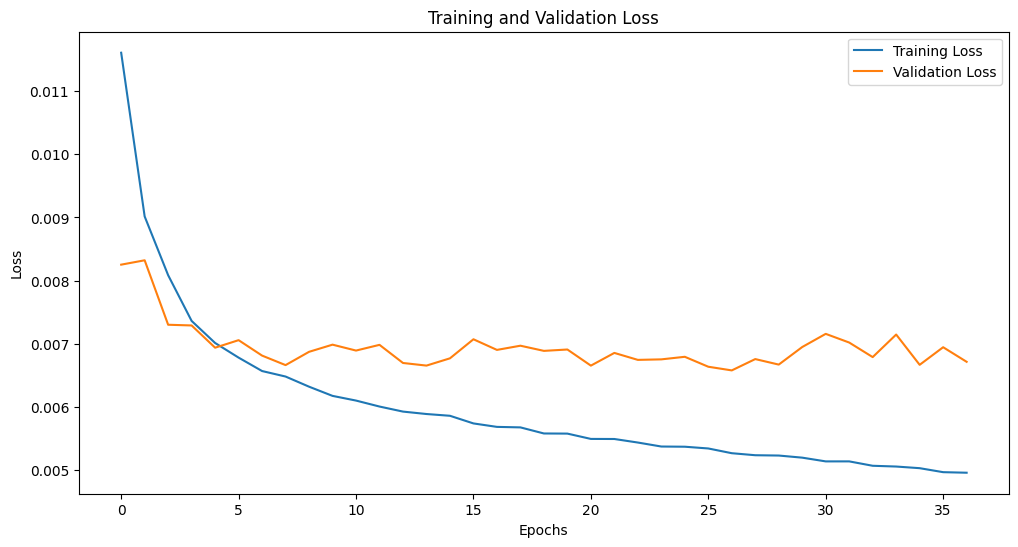

In [24]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))  # Optional: Set figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step


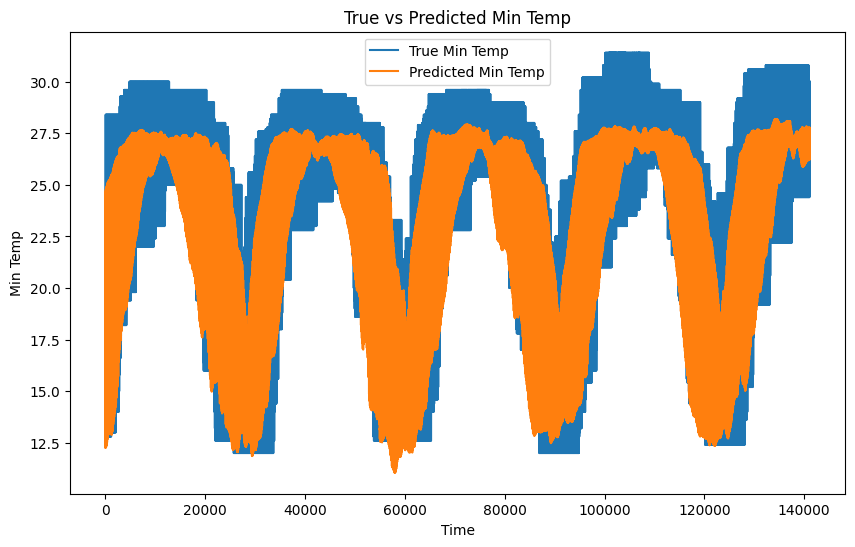

In [25]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predicted values to match the test data shape
predicted_data = predictions.reshape(-1, predictions.shape[-1])

# Rescale the predicted values back to their original scale
predicted_data_rescaled = scaler.inverse_transform(predicted_data)

# Reshape the test data to match the predicted shape
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the test data back to its original scale for comparison
true_data_rescaled = scaler.inverse_transform(y_test_reshaped)

# Plot the actual vs predicted values for one feature (e.g., Min Temp)
plt.figure(figsize=(10, 6))
plt.plot(true_data_rescaled[:, 0], label='True Min Temp')
plt.plot(predicted_data_rescaled[:, 0], label='Predicted Min Temp')
plt.title('True vs Predicted Min Temp')
plt.xlabel('Time')
plt.ylabel('Min Temp')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Reshape the test and predicted data
predicted_data = predictions.reshape(-1, predictions.shape[-1])
true_data_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Rescale the predicted and true data back to their original scales
predicted_data_rescaled = scaler.inverse_transform(predicted_data)
true_data_rescaled = scaler.inverse_transform(true_data_reshaped)

# Calculate the errors for one feature (e.g., Min Temp, which is index 0)
mae = mean_absolute_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0])
rmse = np.sqrt(mean_squared_error(true_data_rescaled[:, 0], predicted_data_rescaled[:, 0]))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 1.6993017196655273
Root Mean Squared Error (RMSE): 2.1524221897125244


In [27]:
# Use the last sequence from the test data to predict future weather
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_train.shape[2])  # Ensure correct shape

# Predict future weather (for the next 90 days, for example)
future_prediction = model.predict(last_sequence)

# Reshape the predicted data to 2D for inverse transformation (batch size is 1, so we remove it)
future_prediction_reshaped = future_prediction.reshape(future_prediction.shape[1], future_prediction.shape[2])

# Inverse transform the prediction back to the original scale
future_weather = scaler.inverse_transform(future_prediction_reshaped)

print(f"Predicted future weather for the next 90 days: \n{future_weather}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted future weather for the next 90 days: 
[[  27.315496    33.591095    80.85985    998.87134     11.462593 ]
 [  27.178762    33.56003     80.532196   998.3182      10.506701 ]
 [  27.388952    33.871075    80.89441    999.0558       9.893274 ]
 [  27.50326     33.966427    80.27461    999.0005       9.621782 ]
 [  27.278065    33.785393    80.75234    998.92676     11.26743  ]
 [  27.494877    33.641506    80.83665    999.42584     10.108122 ]
 [  27.600197    33.57571     81.17875    998.6231      11.360223 ]
 [  27.200504    33.498863    81.04639    999.09705     11.329084 ]
 [  27.190472    33.56844     81.08225    998.91046     11.227468 ]
 [  27.289404    33.47764     81.049324   999.7115      10.734219 ]
 [  27.363857    33.59583     81.03755    999.128        9.847974 ]
 [  27.439333    33.401615    80.8843     999.6686      11.101363 ]
 [  27.501602    33.60675     80.57481    999.0727      11.0034485]
 [  27.359072    33.492466   